# LLA to ECEF with Optional Savitzky–Golay Smoothing

This notebook evaluates whether a Savitzky–Golay (SG) filter should be applied to **Latitude, Longitude, Altitude (LLA)** time-series before converting to **Earth-Centered, Earth-Fixed (ECEF)** coordinates and estimating velocities by finite differences.

For each `(window_length, polyorder)` pair:
- Apply SG to the LLA time series
- Converts the smoothed LLA to ECEF
- Computes velocities by finite differences of ECEF over time
- Evaluates metrics to judge good smoothing vs distortion:
    - **Noise metric**: median norm of consecutive velocity increments (lower is smoother).
    - **Curvature metric**: median norm of second differences of positions (lower is smoother).
    - **Path length distortion**: relative change in total path distance (should be very small).

A composite score balances these criteria; lower is better. We then decide if SG is needed by requiring at least **10% noise reduction** with at most **1% path distortion**


## Requirements and Data

- Input CSV (no header) at `SciTec_code_problem_data.csv` with columns:  
  `time_s, lat_deg, lon_deg, alt_km`  
- WGS‑84 constants are taken from the reference (semi-major axis `a`, flattening `f`, eccentricity squared `e^2 = f(2-f)`).

In [1]:
%pip install -U numpy pandas scipy matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from scipy.signal import savgol_filter

In [3]:
# WGS84 parameters from LLAtoECEF.pdf reference
WGS84_A = 6378137.0 #semi major axis in meters (Earth's equatorial radius)
WGS84_F = 1 / 298.257223563 #flattening ratio
WGS84_E2 = WGS84_F * (2 - WGS84_F) #square of first eccentricity ≈ 0.0066943799901413165

In [4]:
def lla_to_ecef(lat_deg: np.ndarray, lon_deg: np.ndarray, alt_m: np.ndarray) -> np.ndarray:
    """
    Convert geodetic coordinates (latitude, longitude, altitude) to ECEF (Earth-Centered, Earth-Fixed) XYZ.

    Parameters
    ----------
    lat_deg : np.ndarray
        Geodetic latitude in **degrees** (WGS84), positive north.
    lon_deg : np.ndarray
        Geodetic longitude in **degrees** (WGS84), positive east.
    alt_m : np.ndarray
        Altitude above the WGS84 ellipsoid in **meters**.

    Returns
    -------
    np.ndarray
        Array of shape (N, 3) where each row is [X, Y, Z] in **meters**, in the ECEF frame.
        ECEF frame is centered at Earth's center:
          - X-axis passes through latitude 0°, longitude 0°
          - Y-axis passes through latitude 0°, longitude 90°E
          - Z-axis passes through the North Pole

    Notes
    -----
    - Uses WGS84 ellipsoid (semi-major axis WGS84_A and first eccentricity squared WGS84_E2).
    - Vectorized: accepts arrays and computes all points at once.
    """
    # Convert degrees to radians for trig functions
    lat = np.deg2rad(lat_deg)
    lon = np.deg2rad(lon_deg)

    # Precompute sines/cosines (faster and clearer than recomputing)
    sin_lat = np.sin(lat)
    cos_lat = np.cos(lat)
    cos_lon = np.cos(lon)
    sin_lon = np.sin(lon)

    # Radius of curvature in the prime vertical: N(phi) = a / sqrt(1 - e^2 sin^2(phi))
    N = WGS84_A / np.sqrt(1.0 - WGS84_E2 * sin_lat**2)

    # Standard geodetic to ECEF conversion
    X = (N + alt_m) * cos_lat * cos_lon
    Y = (N + alt_m) * cos_lat * sin_lon
    Z = (N * (1.0 - WGS84_E2) + alt_m) * sin_lat

    # Stack columns into (N, 3) array
    return np.column_stack((X, Y, Z))


In [5]:
def load_and_clean_lla(csv_path: Path):
    """
    Load a CSV of LLA time series and return clean, typed, and de-duplicated arrays.

    The CSV is expected to have no header and four columns in order:
      [time_s, lat_deg, lon_deg, alt_km]

    Steps performed:
      1) Read the file with explicit column names.
      2) Drop rows with any missing values.
      3) Convert columns to float64 numpy arrays.
      4) Convert altitude from kilometers to meters.
      5) Sort all arrays by ascending time.
      6) Remove duplicate timestamps (keep the first occurrence).

    Parameters
    ----------
    csv_path : Path
        Path to the input CSV file.

    Returns
    -------
    (t, lat, lon, alt_m) : tuple of np.ndarray
        - t      : time in seconds (float64), strictly increasing
        - lat    : latitude in degrees (float64)
        - lon    : longitude in degrees (float64)
        - alt_m  : altitude in meters (float64)
    """
    # Load CSV, assign column names, drop rows with any NaNs, reindex to 0..N-1
    df = pd.read_csv(csv_path, header=None, names=["time_s","lat_deg","lon_deg","alt_km"])\
           .dropna().reset_index(drop=True)
    
    # Convert columns to numpy arrays of float64
    t = df["time_s"].to_numpy(dtype=np.float64)
    lat = df["lat_deg"].to_numpy(dtype=np.float64)
    lon = df["lon_deg"].to_numpy(dtype=np.float64)

    # Convert altitude from km to m to match ECEF function inputs
    alt_m = (df["alt_km"].to_numpy(dtype=np.float64)) * 1000.0

    # Sort by time so downstream finite differences and path metrics behave correctly
    order = np.argsort(t)
    t, lat, lon, alt_m = t[order], lat[order], lon[order], alt_m[order]

    # Build a mask to keep only the first occurrence of each unique timestamp
    unique_mask = np.ones_like(t, dtype=bool)
    unique_mask[1:] = t[1:] != t[:-1]

    # Return deduplicated, sorted arrays
    return t[unique_mask], lat[unique_mask], lon[unique_mask], alt_m[unique_mask]

In [6]:
def finite_diff_velocity(t: np.ndarray, r: np.ndarray) -> np.ndarray:
    """
    Compute velocity via first-order forward finite differences on position samples.

    Parameters
    ----------
    t : np.ndarray
        1D array of sample times (seconds), length N; should be strictly increasing,
        but function guards against non-increasing intervals.
    r : np.ndarray
        2D array of positions of shape (N, 3) in meters (e.g., ECEF coordinates).

    Returns
    -------
    np.ndarray
        Velocity array of shape (N, 3) in meters/second.
        - v[0] is left as [0,0,0] (no backward point).
        - For i >= 1, v[i] = (r[i] - r[i-1]) / (t[i] - t[i-1]) when dt > 0, else [0,0,0].

    Notes
    -----
    - This is a simple first-order estimate; for smoother results consider central differences
      or filtering the position first.
    """
    # Initialize output with zeros (same shape as positions)
    v = np.zeros_like(r, dtype=np.float64)

    # Time and position deltas between consecutive samples
    dt = np.diff(t)
    dr = np.diff(r, axis=0)

    # Guard against zero/negative dt to avoid division by zero or nonsense velocities
    valid = dt > 0

    # Compute per-step velocity where valid; broadcast dt to (N-1, 3)
    v[1:][valid] = dr[valid] / dt[valid, None]

    # Return the computed velocity array
    return v

In [7]:
def speed(v: np.ndarray) -> np.ndarray:
    """
    Compute scalar speed (Euclidean norm) from a velocity vector time series.

    Parameters
    ----------
    v : np.ndarray
        Velocity array of shape (N, 3) in meters/second.

    Returns
    -------
    np.ndarray
        1D array of length N with speed in meters/second: ||v|| for each sample.
    """
    return np.linalg.norm(v, axis=1)

In [8]:
def total_path_length(r: np.ndarray) -> float:
    """
    Compute the total path length traveled along a polyline of positions.

    Parameters
    ----------
    r : np.ndarray
        Positions of shape (N, 3) in meters.

    Returns
    -------
    float
        Sum of segment lengths in meters:
        sum_i || r[i] - r[i-1] || for i = 1..N-1.
    """
    # Segment-wise displacement magnitudes
    seg = np.linalg.norm(np.diff(r, axis=0), axis=1)

    # Sum and return total path length
    return float(np.sum(seg))

In [9]:
def noise_metric(v: np.ndarray) -> float:
    """
    Heuristic 'noise' metric for a velocity time series: median magnitude of velocity increments.

    Rationale
    ---------
    If velocity estimates are jittery/noisy, consecutive velocity vectors will change a lot.
    The median of ||v[i] - v[i-1]|| captures typical step-to-step variability while being
    robust to outliers.

    Parameters
    ----------
    v : np.ndarray
        Velocity array of shape (N, 3).

    Returns
    -------
    float
        Median increment magnitude (m/s). Returns 0.0 if not enough samples.
    """
    dv = np.diff(v, axis=0)
    inc = np.linalg.norm(dv, axis=1)
    return float(np.median(inc)) if inc.size else 0.0

In [10]:
def curvature_metric(r: np.ndarray) -> float:
    """
    Simple curvature/change-of-direction proxy based on second differences of position.

    Rationale
    ---------
    For uniformly sampled positions, the second finite difference r[i+1] - 2r[i] + r[i-1]
    correlates with local curvature/acceleration. The median norm gives a robust summary
    of how 'bendy' or rapidly changing the track is.

    Parameters
    ----------
    r : np.ndarray
        Positions of shape (N, 3) in meters.

    Returns
    -------
    float
        Median norm of second differences (meters). Returns 0.0 if not enough samples.
    """
    d1 = np.diff(r, axis=0)
    d2 = np.diff(d1, axis=0)
    curv = np.linalg.norm(d2, axis=1)
    return float(np.median(curv)) if curv.size else 0.0

In [11]:
def composite_score(noise_before, noise_after, path_before, path_after, curv_before, curv_after):
    """
    Combine multiple before/after metrics into a single scalar score to compare smoothing runs.

    The idea is to reward reductions in noise/curvature while penalizing large path-length drift.

    Parameters
    ----------
    noise_before : float
        Noise metric before filtering.
    noise_after : float
        Noise metric after filtering.
    path_before : float
        Total path length before filtering (meters).
    path_after : float
        Total path length after filtering (meters).
    curv_before : float
        Curvature metric before filtering.
    curv_after : float
        Curvature metric after filtering.

    Returns
    -------
    float
        Lower is better. Defined as a weighted sum of normalized ratios:
          0.6 * (noise_after / noise_before)
        + 0.3 * (curv_after  / curv_before)
        + 0.1 * |path_after - path_before| / path_before

    Notes
    -----
    - A tiny epsilon is added to denominators to avoid divide-by-zero.
    - Weights (0.6, 0.3, 0.1) emphasize noise reduction, then curvature, with a small penalty
      for path-length deviation so we don't over-smooth and distort trajectory length.
    - You can tune weights to match your application’s priorities.
    """
    eps = 1e-12
    noise_improve = (noise_after + eps) / (noise_before + eps)
    curv_improve  = (curv_after  + eps) / (curv_before  + eps)
    path_change   = abs(path_after - path_before) / (path_before + eps)
    return 0.6*noise_improve + 0.3*curv_improve + 0.1*path_change

In [12]:
# Load data
DATA_PATH = Path("SciTec_code_problem_data.csv")
t, lat, lon, alt_m = load_and_clean_lla(DATA_PATH)

# Baseline ECEF & velocity
r_base = lla_to_ecef(lat, lon, alt_m)
v_base = finite_diff_velocity(t, r_base)

# Build a baseline metrics dictionary summarizing the unfiltered/original trajectory.
baseline = {
    'noise': noise_metric(v_base),
    'curv':  curvature_metric(r_base),
    'path':  total_path_length(r_base),
}
baseline

{'noise': 27.33740247997508,
 'curv': 136.52440348435627,
 'path': 9724303.933477506}

In [13]:
# Parameter sweep for SG

# Candidate SG window lengths (samples). SG requires an 
# ODD window and window_length > polyorder
window_lengths = [5,7,9,11,13,15,21,31,41,51,61,81,101]

# Candidate SG polynomial orders to fit within each window
polyorders = [2,3,4]

# Accumulate one result dict per (window_length, polyorder) combination
results = []

# Try every window length / polyorder combo
for wl in window_lengths:
    for po in polyorders:

        # Skip invalid SG configurations:
        # window must be odd; - window_length must exceed polyorder
        if wl % 2 == 0 or wl <= po:
            continue

        # Apply SG smoothing to each LLA series using the same (wl, po).
        # mode="interp" uses polynomial interpolation at the edges to avoid shrinking the array
        lat_f = savgol_filter(lat, wl, po, mode="interp")
        lon_f = savgol_filter(lon, wl, po, mode="interp")
        alt_f = savgol_filter(alt_m, wl, po, mode="interp")

        # Convert the smoothed LLA samples to ECEF XYZ (meters)
        r = lla_to_ecef(lat_f, lon_f, alt_f)

        # Estimate velocity via finite differences on ECEF positions
        v = finite_diff_velocity(t, r)

        # Package evaluation metrics for this configuration:
        # noise: jitter in velocity (lower is better)
        # curv : curvature proxy from second differences (lower is better for smoothing)
        # path : total distance traveled (we prefer not to change it much)
        res = {
            'window_length': wl,
            'polyorder': po,
            'noise': noise_metric(v),
            'curv': curvature_metric(r),
            'path': total_path_length(r),
        }

        # Combine before/after metrics into a single score (lower is better)
        # Uses baseline values (from the unsmoothed series) versus current results
        res['score'] = composite_score(baseline['noise'], res['noise'],
                                       baseline['path'],  res['path'],
                                       baseline['curv'],  res['curv'])
        
        # Save this configuration’s outcome
        results.append(res)

# Create a DataFrame of all tested configurations, sort by best (lowest) score,
# and reset the index for clean display
res_df = pd.DataFrame(results).sort_values('score').reset_index(drop=True)
res_df.head(10)

,window_length,polyorder,noise,curv,path,score
0,101,2,25.752124,128.745470,9.899566e+06,0.849915
1,101,4,26.884921,134.271537,9.751571e+06,0.885399
2,81,3,26.992624,134.934011,9.741667e+06,0.889117
3,81,4,27.031733,135.002460,9.749676e+06,0.890208
4,81,2,27.029718,134.992231,9.844590e+06,0.891117
5,101,3,27.101592,135.349769,9.769889e+06,0.892712
6,41,4,27.144418,135.690910,9.730658e+06,0.893998
7,61,3,27.143763,135.687719,9.743125e+06,0.894105
8,61,2,27.143763,135.687719,9.780620e+06,0.894491
9,51,2,27.182210,135.751639,9.752031e+06,0.895181


In [14]:
# Pick the best (lowest-score) SG configuration if any results exist; otherwise None
best = res_df.iloc[0] if len(res_df) else None

if best is not None:

    # Fractional reduction in velocity 'noise' vs. baseline, guarded by tiny eps in denominator
    # Positive value => noise decreased; 0 => no change; negative => noise got worse
    noise_reduction = (baseline['noise'] - best['noise']) / max(baseline['noise'], 1e-12)

    # Fractional change in total path length vs. baseline (absolute, so only magnitude matters)
    # Small values mean the smoothing did not distort trajectory length much
    path_distortion = abs(best['path'] - baseline['path']) / max(baseline['path'], 1e-12)

    # Fractional reduction in curvature metric vs. baseline (positive => less bendiness/jitter)
    curv_reduction  = (baseline['curv'] - best['curv']) / max(baseline['curv'], 1e-12)

    # Simple decision rule for whether SG is worthwhile:
    # Require at least 10% noise reduction AND
    # Require path distortion no more than 1%
    sg_needed = (noise_reduction >= 0.10) and (path_distortion <= 0.01)

    # Report the best SG parameters and their composite score and metrics
    print(f"Best SG params: window_length={int(best['window_length'])}, polyorder={int(best['polyorder'])}, score={best['score']:.6g}")
    print(f"Noise Δ: {-noise_reduction*100:.2f}% | Curvature Δ: {-curv_reduction*100:.2f}% | Path distortion: {path_distortion*100:.3f}%")
    # Final decision summary based on the rule above.
    print("Decision:", "APPLY SG" if sg_needed else "NO SG NEEDED")
else:
    # No valid SG configurations were produced
    print("No valid SG combos produced.")

Best SG params: window_length=101, polyorder=2, score=0.849915
Noise Δ: -5.80% | Curvature Δ: -5.70% | Path distortion: 1.802%
Decision: NO SG NEEDED


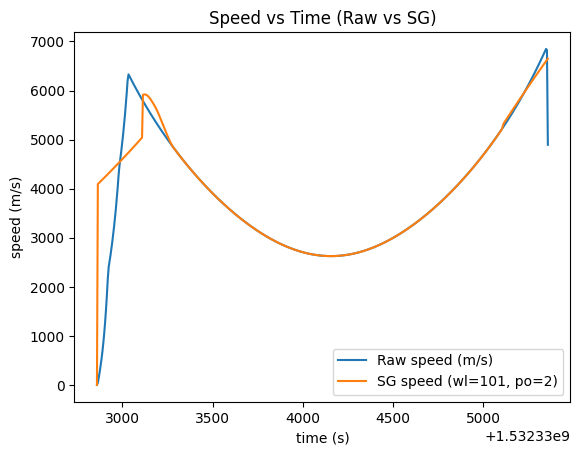

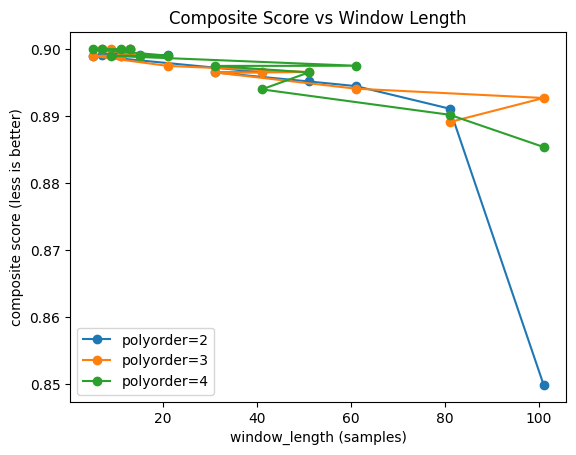

In [15]:
# Plot speed time series: raw vs SG-best (if applicable)
plt.figure()
# Plot the baseline (unsmoothed) speed over time for reference
plt.plot(t, speed(v_base), label="Raw speed (m/s)")

# If we have SG results, re-compute speed using the best (wl, po) and overlay it
if len(res_df):
    # Extract best Savitzky–Golay parameters chosen earlier
    wl = int(best['window_length']); po = int(best['polyorder'])

    # Apply SG smoothing to each LLA component with the selected parameters.
    # mode="interp" keeps the output length equal to the input length and handles edges smoothly
    lat_f = savgol_filter(lat, wl, po, mode="interp")
    lon_f = savgol_filter(lon, wl, po, mode="interp")
    alt_f = savgol_filter(alt_m, wl, po, mode="interp")

    # Convert the smoothed LLA back to ECEF, then derive velocity via finite differences
    r_f = lla_to_ecef(lat_f, lon_f, alt_f)
    v_f = finite_diff_velocity(t, r_f)
    
    # Overlay the smoothed speed curve for direct comparison with the raw speed
    plt.plot(t, speed(v_f), label=f"SG speed (wl={wl}, po={po})")

# Label axes, add title & legend, and render the figure
plt.xlabel("time (s)"); plt.ylabel("speed (m/s)")
plt.title("Speed vs Time (Raw vs SG)"); plt.legend(); plt.show()

# Score vs window length (per polyorder)
plt.figure()

# For each polyorder, draw a curve of score vs. window_length so we can see trends
for po in sorted(res_df['polyorder'].unique()):
    # Subset results for this polynomial order
    sub = res_df[res_df['polyorder']==po]
    
    # Plot score as a function of window length (lower is better).
    plt.plot(sub['window_length'], sub['score'], marker='o', linestyle='-', label=f'polyorder={int(po)}')

# Label axes, add title & legend, and render the figure.
plt.xlabel("window_length (samples)"); plt.ylabel("composite score (less is better)")
plt.title("Composite Score vs Window Length"); plt.legend(); plt.show()